# LANDARTs - Landsat automatic retrieval of surface temperatures

LANDARTs is a Python tool that works (currently) only with Landsat archives in the new metadata file format (data acquired after 2012) that can be downloaded from the [USGS website](https://earthexplorer.usgs.gov/).

In [51]:
import glob, subprocess, os
import rasterio
import rasterio.plot
import rasterio.mask
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx

**Set directory**

In [2]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_nb        = '99'

# Directory for all work files
work_path = f'{computer_path}STUDENTS/GROUP_{grp_nb}/TP/'

# Input directory
roi_path     = f'{work_path}ROI/'
landsat_path = f'{work_path}LANDSAT/'

# Output directory
lst_path = f'{work_path}LST/'

Path(lst_path).mkdir(parents=True, exist_ok=True)

**Set region of interest**

In [12]:
crs = 'EPSG:32631'

roi_name     = 'extent_roi_v2'
roi_filename = f'{roi_name}_{crs[5:]}.shp'
roi_file     = f'{roi_path}{roi_filename}'

roi_gdf = gpd.read_file(roi_file)

print(f'ROI shapefile : {roi_file}')

ROI shapefile : /export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_99/TP/ROI/extent_roi_v2_32631.shp


**Set parameters**

In [5]:
nodata_val = -9999

#'TODO set np.NAN before converting degree!!!!!'

## 1. Get Land Surface Temperature (LST) using LANDARTs

**To be launch on the lab'servers by the assistant - LANDARTs tool can not be installed in computer room !**

In [6]:
for input_file in glob.glob(f'{landsat_path}*.tar.gz'):
        
    output_file = f'{lst_path}{os.path.basename(input_file)[:-7]}_LST.tif'

    if not os.path.isfile(output_file):
        
        cmd = 'bash launch_landarts.sh'
        cmd += f' {input_file}'
        cmd += f' {output_file}'

        subprocess.call(cmd, shell=True)

        print(os.path.basename(input_file))
        print('is converted to')
        print(os.path.basename(output_file))
    else:

        print(f'LST file already exist !')

LST file already exist !


## 2. Preprocess LST images

2.1 Mask invalid pixels

2.2 Convert Kelvin to Celsius degree

In [39]:
list_im_to_process = glob.glob(f'{lst_path}*_LST.tif')

print(f'There are {len(list_im_to_process)} images to preprocess')

for im_file in list_im_to_process:

    im_file_prepro = f'{lst_path}{os.path.basename(im_file)[:-4]}_Celsius_BQA.tif'
    
    if not os.path.isfile(im_file_prepro):

        # Get date of image
        date = os.path.basename(im_file)[17:17+8]
        print(f'Date : {date}')

        # Find QA band corresponding to the given Landsat image
        bqa_file = glob.glob(f'{landsat_path}*{date}*_BQA.TIF')[0]
        
        print(im_file)
        print(bqa_file)
        
        # Open Thermal band file
        src_im = rasterio.open(im_file, "r")
        im = src_im.read(1)

        # Open Quality Assessment band 
        src_bqa = rasterio.open(bqa_file, "r")
        BQA = src_bqa.read(1)

        #####################
        ### Apply QA band ###
        #####################

        # Change invalid pixels categories by NaN
        BQA = BQA.astype(float)
        BQA = np.where(BQA == 2720, 1, np.nan)

        # Mask thermal band with BQA
        im_bqa = im * BQA
        
        #########################################
        ### Convert Kelvin to degrees Celsius ###
        #########################################
        
        im_bqa_celsius = im_bqa / 100 - 273.15

        # Chnage Numpy nan by no data value
        im_bqa_celsius[np.isnan(im_bqa_celsius)] = nodata_val

        # Update metadata
        meta = src_im.meta.copy()

        meta.update(nodata=nodata_val,
                    dtype= "float32")
                
        # Write output image
        dst = rasterio.open(im_file_prepro, "w", **meta)
        dst.write(im_bqa_celsius,1)

        # Close rasterio objects
        src_im.close()
        src_bqa.close()
        dst.close()


        print(f'A new raster file is created : {im_file_prepro}')

print('--> All images are masked and converted to Celsius degrees !')

Date : 20180804
--> All images are masked and converted to Celsius degrees !


## 3. Clip images to the extent of Region of Interest

We can use our ROI (vector) to clip satellite images (raster) into a smaller area to reduce image storage and speed up further processing.

In [40]:
list_im_to_clip = glob.glob(f'{lst_path}*_Celsius_BQA.tif')

print(f'There are {len(list_im_to_clip)} images to clip')

There are 1 images to clip


**Check if the ROI is located in one of the image to clip**

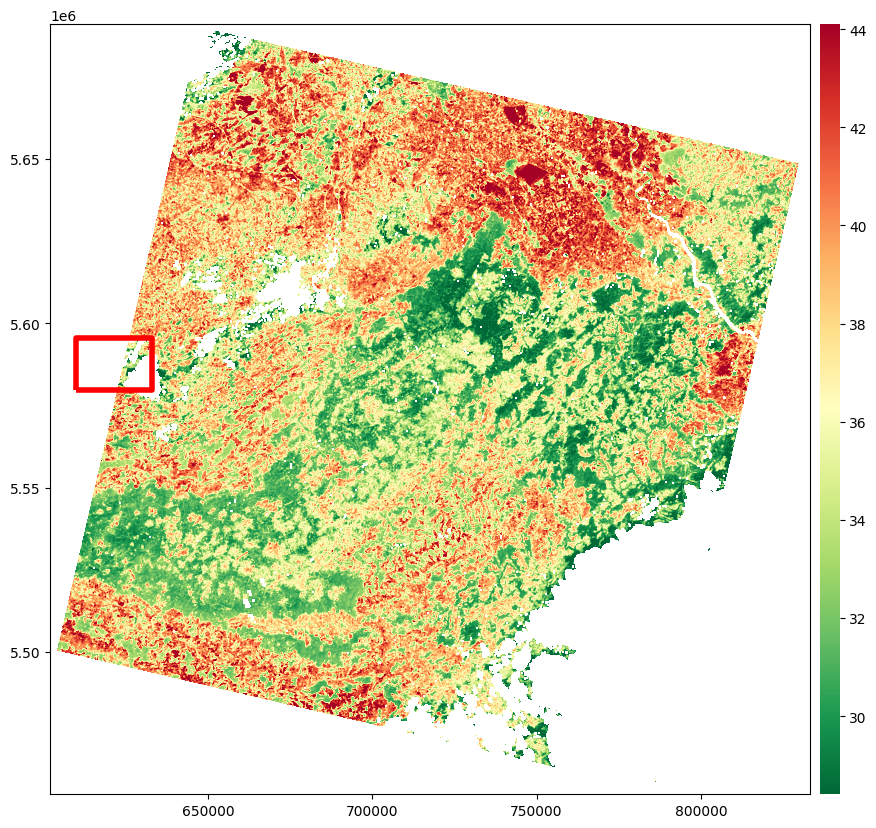

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot first image of the list
im_file = list_im_to_clip[0]
src = rasterio.open(im_file, "r")
im = src.read(1)

color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

im = im.astype(float)
im = np.where(im == nodata_val, np.nan, im)
p5 = np.nanpercentile(im, 2)
p95 = np.nanpercentile(im, 98)

im_rio = rasterio.plot.show(src, cmap=reversed_color_map, vmin=p5, vmax=p95, ax=ax)
im_rio = im_rio.get_images()[0]

# Plot ROI vector
roi_gdf.plot(facecolor='none', edgecolor='red', linewidth = 4, ax=ax)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)
plt.box(False)

In [45]:
for im_file in list_im_to_clip:

    im_file_clipped = f'{lst_path}{os.path.basename(im_file)[:-4]}_ROI.tif'
    
    if not os.path.isfile(im_file_clipped):
        
        # Open file
        src = rasterio.open(im_file, "r")

        im_clipped, out_transform = rasterio.mask.mask(src,
                                                      roi_gdf.geometry,
                                                      all_touched=True,
                                                      crop=True)

        # Update metadata
        meta = src_im.meta.copy()

        meta.update(width = im_clipped.shape[2],
                    height = im_clipped.shape[1],
                    transform = out_transform,
                    nodata=nodata_val,
                    dtype= "float32")
        
        print(meta)
        
        # Write clipped image
        dst = rasterio.open(im_file_clipped, "w", **meta)
        dst.write(im_clipped)

        # Close rasterio objects
        src.close()
        dst.close()


        print(f'A new raster file is created : {im_file_clipped}')

print('--> All images are clipped !')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999, 'width': 768, 'height': 529, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(30.0, 0.0, 609795.0,
       0.0, -30.0, 5595555.0)}
A new raster file is created : /export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_99/TP/LST/LC08_L1TP_197025_20180804_20180814_01_T1_LST_Celsius_BQA_ROI.tif
--> All images are clipped !


**Plot last clipped image**

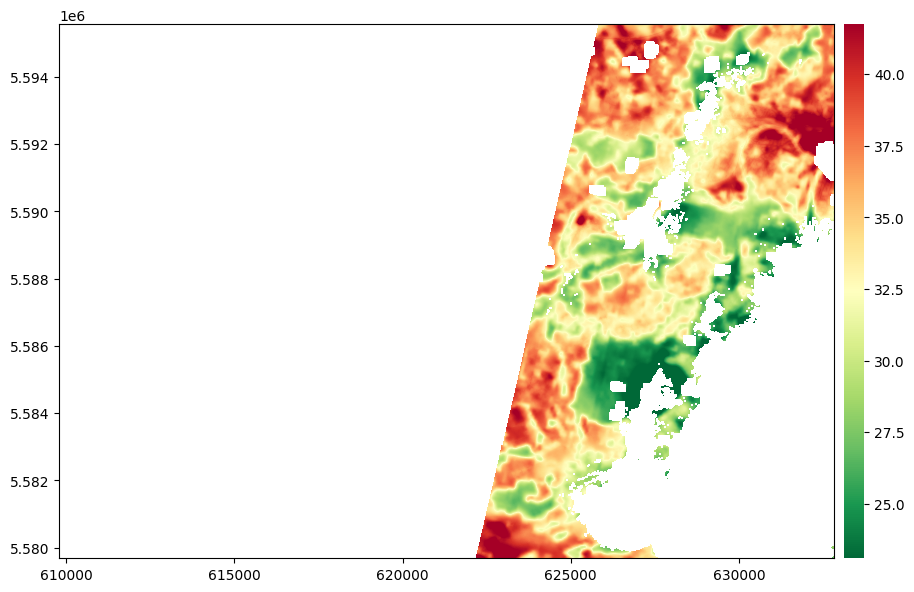

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

im_file = im_file_clipped

src = rasterio.open(im_file, "r")
im = src.read(1)

color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()

im = im.astype(float)
im = np.where(im == nodata_val, np.nan, im)
p5 = np.nanpercentile(im, 2)
p95 = np.nanpercentile(im, 98)

im_rio = rasterio.plot.show(src, cmap=reversed_color_map, vmin=p5, vmax=p95, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)
plt.box(False)